In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from data_gen import get_agent_distribution_and_losses_nels
import itertools
import bisect

In [2]:
def get_final_beta(df, method):
    l = [float(x) for x in list(df[df["method"]==method]["final_beta"].item()[1:-1].split(","))]
    arr = np.array(l).reshape(len(l), 1)
    return arr

def get_score_distribution(agent_dist, beta, sigma, q):
    s_eq = agent_dist.quantile_fixed_point_true_distribution(beta, sigma, q)
    scores = agent_dist.best_response_noisy_score_distribution(beta, s_eq, sigma)
    return scores

def get_socio_econ(agent_dist):
    socio_econ = 1/np.array([gamma[0].item() for gamma in agent_dist.types["gammas"]])
    n_socio_econ = socio_econ[agent_dist.n_agent_types]
    normalized_socio_econ = (socio_econ- min(socio_econ))/(max(socio_econ)-min(socio_econ))
    return n_socio_econ, normalized_socio_econ

def get_accepted_scores_by_type(agent_dist, agent_type, scores, cutoff):
    type_indicator = agent_dist.n_agent_types == agent_type
    return scores[type_indicator]

In [3]:
beta_bar = np.ones(9)/np.sqrt(9)
agent_dist, all_types_and_losses, all_labels, _,_, _, sigma = get_agent_distribution_and_losses_nels(n=5000, n_clusters=8,
                                                                                              prev_beta=beta_bar, 
                                                                                              seed=0)
q=0.7

df = pd.read_csv("results/nels_socio_econ_12-11-23.csv")
df = df[df["seed"] == 0]
beta_pe = get_final_beta(df, "total_deriv")
beta_me = get_final_beta(df, "partial_deriv_loss_beta")
beta_naive = get_final_beta(df, "ewm")

/home/users/rsahoo/miniconda3/envs/competing_agents/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [11]:
list([round(x, 3) for x in beta_naive.flatten()] )

[0.06, 0.34, -0.017, -0.395, 0.041, 0.706, -0.191, -0.305, -0.306]

In [12]:
list([round(x, 3) for x in beta_pe.flatten()] )

[0.017, 0.056, 0.061, 0.009, -0.523, -0.395, -0.413, -0.552, -0.297]

In [13]:
list([round(x, 3) for x in beta_me.flatten()] )

[0.484, 0.413, 0.51, 0.452, 0.151, 0.139, 0.204, 0.089, 0.196]

In [9]:
def plot_score_dist(ax, agent_dist, beta, sigma, q, title):
    scores = get_score_distribution(agent_dist, beta, sigma, q)
    n_socio_econ, normalized_socio_econ = get_socio_econ(agent_dist)
    
    bins = [-0.01, 0.333, 0.666, 1.1]
    colors = ['#ffbe0b', '#fb5607', '#ff006e', '#8338ec']
    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors)-1 )
    
    cutoff = np.quantile(scores, q)
    ax.axvline(x=cutoff, c="black", label="Threshold")

    for i in range(agent_dist.n_types):
        socio_econ_i = normalized_socio_econ[i]
        idx = bisect.bisect_left(bins, socio_econ_i) - 1
        ax.hist(get_accepted_scores_by_type(agent_dist, i, scores, cutoff), alpha=0.7, color=colors[idx])
    ax.set_title(title, fontsize=20)
    ax.legend(fontsize=18)
    #ax.set_xlim(1, 26)
    ax.set_ylim(1, 300)
    ax.set_xlabel("Scores", fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    return normalized_socio_econ

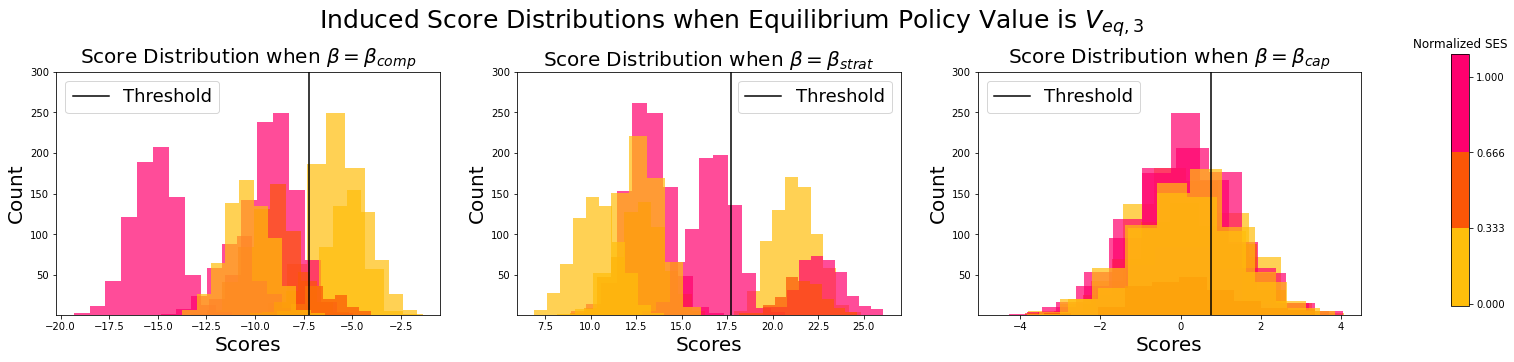

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5))
normalized_socio_econ = plot_score_dist(axs[0], agent_dist, beta_pe, sigma, q, "Score Distribution when " +r"$\beta=\beta_{comp}$")
plot_score_dist(axs[1], agent_dist, beta_me, sigma, q, "Score Distribution when " +r"$\beta=\beta_{strat}$")
normalized_socio_econ = plot_score_dist(axs[2], agent_dist, beta_naive, sigma, q, "Score Distribution when " +r"$\beta=\beta_{cap}$")

fig.subplots_adjust(right=0.85, top=0.80)
cbar_ax = fig.add_axes([0.90, 0.15, 0.01, 0.7])
cbar_ax.set_title("Normalized SES")


bins = [-0.01, 0.333, 0.666, 1.1]
colors = ['#ffbe0b', '#fb5607', '#ff006e', '#8338ec']
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors)-1 )

cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                boundaries= bins,
                                #extend='both',
                                ticks=[0., 0.333, 0.666, 1.0],
                                spacing='proportional',
                                orientation='vertical')

fig.suptitle("Induced Score Distributions when Equilibrium Policy Value is " + r"$V_{eq, 3}$", fontsize=25)
plt.savefig("figs/paper-figure-9.pdf")

        "F22XRSTD",  # READING STANDARDIZED SCORE
        "F22XMSTD",  # MATHEMATICS STANDARDIZED SCORE
        "F22XSSTD",  # SCIENCE STANDARDIZED SCORE
        "F22XHSTD",  # HISTORY/CIT/GEOG STANDARDIZED SCORE
        "F2RHENG2",  # AVERAGE GRADE IN ENGLISH (HS+B)
        "F2RHMAG2",  # AVERAGE GRADE IN MATHEMATICS (HS+B)
        "F2RHSCG2",  # AVERAGE GRADE IN SCIENCE (HS+B)
        "F2RHSOG2",  # AVERAGE GRADE IN SOCIAL STUDIES (HS+B)
        "F2RHFOG2",  # AVERAGE GRADE IN FOREIGN LANG. (HS+B)